# Загрузка и предобработка данных



In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.stats.diagnostic import lilliefors

In [168]:
# определю функцию для красоты вывода :)
def print_bold(content : str):
    print(f"\033[1m {content} \033[0m")

In [169]:
df = pd.read_csv('data.csv')
df.columns = ["patient", "pressure", "resistance", "drug"]
print_bold("Data sample:")
df.sample(n=5, random_state=7)

 Data sample: 


,patient,pressure,resistance,drug
80,81,68,2300,Галотан
129,130,100,2700,Морфин
3,4,86,2200,Галотан
205,206,89,2400,Морфин
148,149,102,2900,Морфин


In [170]:
print_bold("Data types:")
df.dtypes

 Data types: 


,0
patient,int64
pressure,int64
resistance,int64
drug,object


In [171]:
# убедимся что нет пустых данных
df.isna().sum()

,0
patient,0
pressure,0
resistance,0
drug,0


In [172]:
print_bold("Количество наблюдений по препарату:")
df['drug'].value_counts()

 Количество наблюдений по препарату: 


,count
drug,
Галотан,123
Морфин,117


In [173]:
# сделаю 2 датафрейма для разных препаратов для удобства
halothane = df[df["drug"] == "Галотан"]
morphine = df[df["drug"] == "Морфин"]

# Описательный анализ данных

In [174]:
def stats_df(data : pd.DataFrame, column : str) -> pd.DataFrame:
    result = {
        "Среднее": data[column].mean(),
        "Стандартное отклонение": data[column].std(),
        "Дисперсия": data[column].var(),
        "Медиана": data[column].median(),
        "Мода": data[column].mode(),
        "Первый квартиль": data[column].quantile(0.25),
        "Третий квартиль": data[column].quantile(0.75)
    }
    return pd.DataFrame(result).T.round(2)

def basic_stats(data : pd.DataFrame, drug : str):
    if (drug == "halothane"):
        print_bold("Описательная статистика для Галотана:")
    else:
        print_bold("Описательная статистика для Морфина:")

    print()
    print()

    print_bold("Среднее артериальное давление")
    print(stats_df(data, "pressure"))

    plt.figure(figsize=(4, 2))
    sns.boxplot(x=data["pressure"])
    plt.title("")
    plt.xlabel("")
    plt.show()

    print()
    print()

    print_bold("Общее периферическое сосудистое сопротивление")
    print(stats_df(data, "resistance"))

    plt.figure(figsize=(4, 2))
    sns.boxplot(x=data["resistance"])
    plt.title("")
    plt.xlabel("")
    plt.show()

 Описательная статистика для Галотана: 


 Среднее артериальное давление 
                            0      1
Среднее                 79.24  79.24
Стандартное отклонение   6.50   6.50
Дисперсия               42.31  42.31
Медиана                 80.00  80.00
Мода                    73.00  84.00
Первый квартиль         74.00  74.00
Третий квартиль         84.00  84.00


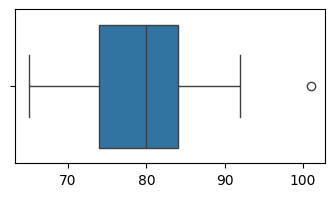



 Общее периферическое сосудистое сопротивление 
                                0
Среднее                   2151.22
Стандартное отклонение     336.41
Дисперсия               113174.73
Медиана                   2200.00
Мода                      2200.00
Первый квартиль           1900.00
Третий квартиль           2400.00


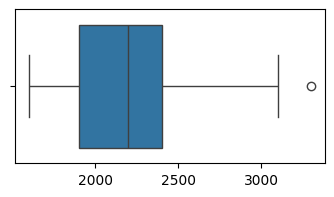

In [175]:
# здесь в давлении две моды, поэтому два столбца
basic_stats(halothane, "halothane")

 Описательная статистика для Морфина: 


 Среднее артериальное давление 
                             0
Среднее                  94.11
Стандартное отклонение    5.39
Дисперсия                29.10
Медиана                  94.00
Мода                    100.00
Первый квартиль          90.00
Третий квартиль          99.00


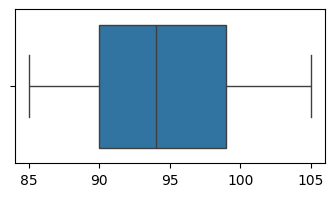



 Общее периферическое сосудистое сопротивление 
                                0
Среднее                   2730.77
Стандартное отклонение     326.02
Дисперсия               106286.47
Медиана                   2800.00
Мода                      2400.00
Первый квартиль           2400.00
Третий квартиль           3000.00


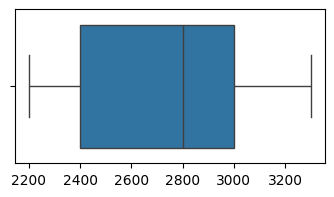

In [176]:
basic_stats(morphine, "morphine")

Видно, что при морфиновой анестезие показатели повыше. Вот и поймем далее в работе, значимо ли они выше или нет

# Проверка нормальности распределения

Для начала просто посмотрим на распределения

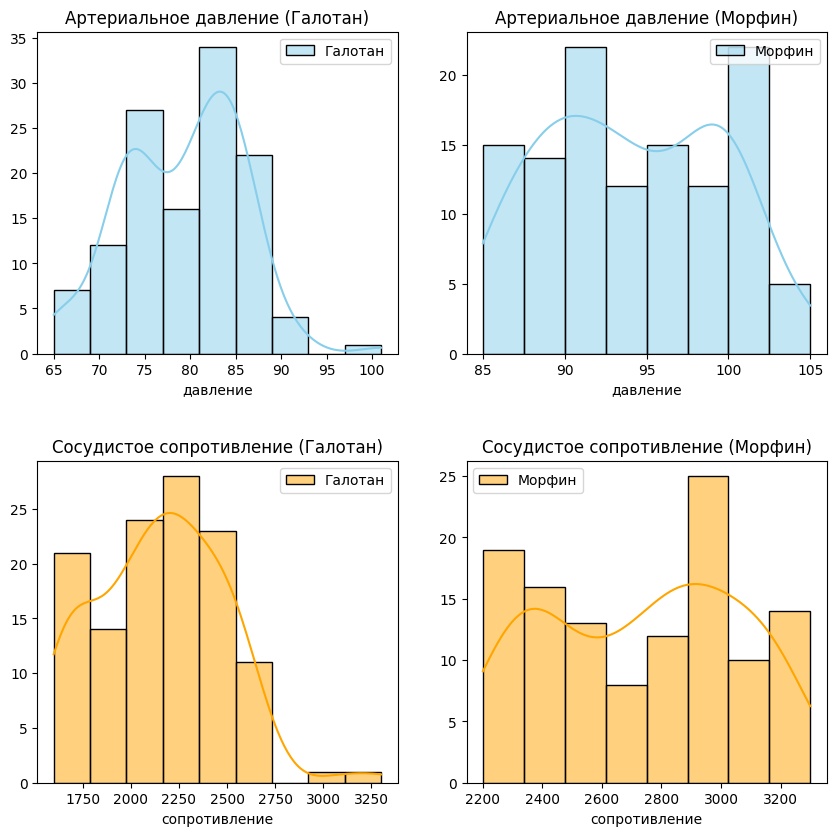

In [177]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

sns.histplot(halothane["pressure"], kde=True, ax=axes[0,0], color="skyblue", label="Галотан")
axes[0,0].set_title("Артериальное давление (Галотан)")
axes[0,0].set_xlabel("давление")
axes[0,0].set_ylabel("")
axes[0,0].legend()

sns.histplot(morphine["pressure"], kde=True, ax=axes[0,1], color="skyblue", label="Морфин")
axes[0,1].set_title("Артериальное давление (Морфин)")
axes[0,1].set_xlabel("давление")
axes[0,1].set_ylabel("")
axes[0,1].legend()

sns.histplot(halothane["resistance"], kde=True, ax=axes[1,0], color="orange", label="Галотан")
axes[1,0].set_title("Сосудистое сопротивление (Галотан)")
axes[1,0].set_xlabel("сопротивление")
axes[1,0].set_ylabel("")
axes[1,0].legend()

sns.histplot(morphine["resistance"], kde=True, ax=axes[1,1], color="orange", label="Морфин")
axes[1,1].set_title("Сосудистое сопротивление (Морфин)")
axes[1,1].set_xlabel("сопротивление")
axes[1,1].set_ylabel("")
axes[1,1].legend()

plt.tight_layout(pad=3.0)
plt.show()

По гистограммам кажется, что нормальных распределений тут нет, а самое близкое к нормальному - у артериального давления для галотана

Теперь используем критерий Шапиро-Уилка и критерий Лиллиефорса для проверки нормальности

In [178]:
def check_normality(data : pd.DataFrame, drug : str, parametr : str, parametr_name : str):
    shapiro_stat, shapiro_p_value = shapiro(data[parametr])
    lilliefors_stat, lilliefors_p_value = lilliefors(data[parametr], dist='norm')
    print_bold(f"{parametr_name} для {drug}:")
    print(f"    Количество наблюдений: {data[parametr].count()}")
    print(f"    p_value Шапиро-Уилк: {round(shapiro_p_value, 3)}")
    print(f"    p_value Лиллиефорс: {round(lilliefors_p_value, 3)}")

check_normality(halothane, "галотана", "pressure", "Артериальное давление")
print()
check_normality(morphine, "морфина", "pressure", "Артериальное давление")
print()
check_normality(halothane, "галотана", "resistance", "Сосудистое сопротивление")
print()
check_normality(morphine, "морфина", "resistance", "Сосудистое сопротивление")

 Артериальное давление для галотана: 
    Количество наблюдений: 123
    p_value Шапиро-Уилк: 0.009
    p_value Лиллиефорс: 0.005

 Артериальное давление для морфина: 
    Количество наблюдений: 117
    p_value Шапиро-Уилк: 0.001
    p_value Лиллиефорс: 0.012

 Сосудистое сопротивление для галотана: 
    Количество наблюдений: 123
    p_value Шапиро-Уилк: 0.001
    p_value Лиллиефорс: 0.065

 Сосудистое сопротивление для морфина: 
    Количество наблюдений: 117
    p_value Шапиро-Уилк: 0.0
    p_value Лиллиефорс: 0.001


**Нулевая гипотеза:**

    Данные в группе распределены нормально

**Альтернативная гипотеза:**

    Данные в группе не имеют нормального распределения

**Уровень значимости - 0.05**

**Результаты:**

*   Артериальное давление для галотана:

    Отвергаем нулевую гипотезу по обоим тестам: данные не имеют нормального распределения

*   Артериальное давление для морфина:

    Отвергаем нулевую гипотезу по обоим тестам: данные не имеют нормального распределения

*   Сосудистое сопротивление для галотана:

    Отвергаем нулевую гипотезу по тесту Шапиро-Уилка, но принимаем по Лиллиефорсу. Примем за результат тест Лиллиефорса, так как Шапиро-Уилк больше подходит для выборок меньшего размера. Итог: распределение можно считать нормальным

*   Сосудистое сопротивление для морфина:

    Отвергаем нулевую гипотезу по обоим тестам: данные не имеют нормального распределения

# Проверка основной гипотезы о различии показателей

В прошлом блоке мы поняли, что 3 из 4 наборов данных не имеют нормального распределения. Также наши выборки независимы (разным пациентам делали разную анестезию). Поэтому будем использовать непараметрический **тест Манна-Уитни**

**Нулевая гипотеза:**

    Распределения давления (сопротивления) в группах галотана и морфина одинаковы

**Альтернативная гипотеза:**

    Распределения давления (сопротивления) в группах галотана и морфина различны

**Уровень значимости - 0.05**

In [179]:
def check_similarity(data_1 : pd.DataFrame, data_2 : pd.DataFrame, parametr : str, parametr_name : str):
    U, p_value = mannwhitneyu(data_1[parametr], data_2[parametr], alternative='two-sided')
    print_bold(f"{parametr_name}:")
    print(f"    U: {U}")
    print(f"    p_value: {round(p_value, 5)}")

check_similarity(halothane, morphine, "pressure", "Артериальное давление")
print()
check_similarity(halothane, morphine, "resistance", "Сосудистое сопротивление")

 Артериальное давление: 
    U: 423.5
    p_value: 0.0

 Сосудистое сопротивление: 
    U: 1685.0
    p_value: 0.0


Нулевая гипотеза принимается

**Вывод:**

И артериальное давление, и сосудистое сопротивление демонстрируют статистически значимые различия, то есть между галотановой и морфиновой анестезией действительно есть разница

Наконец, построим boxplots для наших данных, чтобы наглядно увидеть различие исследуемых параметров:

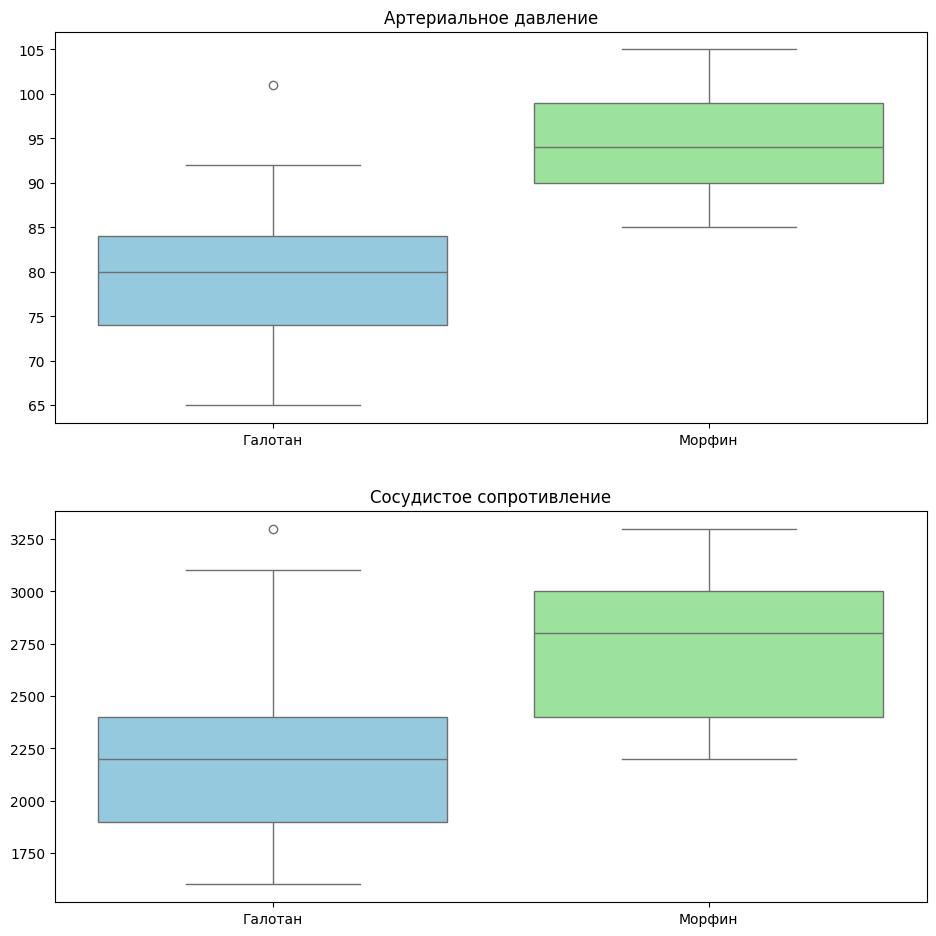

In [180]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.boxplot(ax=axes[0], x="drug", y="pressure", hue="drug", data=df, palette=["skyblue", "lightgreen"], legend=False)
axes[0].set_title("Артериальное давление")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.boxplot(ax=axes[1], x="drug", y="resistance", hue="drug", data=df, palette=["skyblue", "lightgreen"], legend=False)
axes[1].set_title("Сосудистое сопротивление")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout(pad=3.0)
plt.show()